## Loading and preprocessing data

Since time-based information is crucial for electricity demand forecasting, we extract features such as:

- Hour of the day – Captures daily demand patterns.
- Day of the week – Accounts for weekday vs. weekend variations.
- Month – Helps identify seasonal trends.

The original timestamp is dropped since the extracted features contain the relevant time-related information. Finally, the dataset is split into features (X) and target variable (y), where the target variable represents the actual electricity load.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set Global Random Seed for Reproducibility
np.random.seed(42)

# Load dataset
file_path = 'data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# Extract time-based features
data['hour'] = data['utc_timestamp'].dt.hour  # Hour of the day (0-23)
data['day_of_week'] = data['utc_timestamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['month'] = data['utc_timestamp'].dt.month  # Month (1-12)

# Drop the original timestamp column
data = data.drop(columns=['utc_timestamp'])

# Features (X) and target variable (y)
X = data.drop(columns=['DE_load_actual_entsoe_transparency']).values  # Feature matrix
y = data['DE_load_actual_entsoe_transparency'].values  # Target variable


## Data Splitting and standardization

To ensure the model is trained, validated, and tested correctly, we divide the dataset into three parts:

- Training set (70%) – Used to train the model.
- Validation set (15%) – Used to fine-tune hyperparameters.
- Test set (15%) – Used to evaluate the final model's performance.

Since Kernel Ridge Regression is sensitive to the scale of features, we apply standardization using StandardScaler(). Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which improves the model’s stability and performance.

In [4]:
# Split Data into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# Standardize Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Training size: 30676, Validation size: 6574, Test size: 6574


## Model Training


## Linear Kernel 

The linear kernel assumes that there is a simple linear relationship between input features

Alpha=0.1 → Validation MAPE: 1.0364
Alpha=1.0 → Validation MAPE: 1.0364
Alpha=10.0 → Validation MAPE: 1.0364

Best Alpha: 10.0, Best Validation MAPE: 1.0364

Final Test MAPE for Linear Kernel: 1.0348
Final Test MAE: 55874.0350
Final Test RMSE: 55908.7576
Final Test R² Score: -29.9472


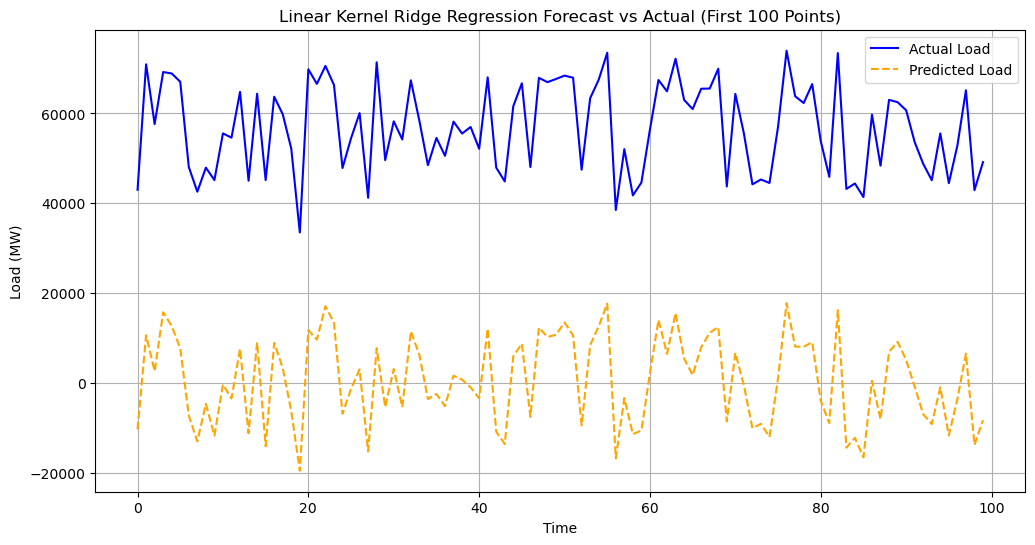

In [ ]:
# Step 1: Tune Alpha Using the Validation Set (No Gamma for Linear Kernel)
best_alpha, best_mape = None, float("inf")
alpha_values = [0.1, 1.0, 10.0]

for alpha in alpha_values:
    krr = KernelRidge(kernel='linear', alpha=alpha)
    krr.fit(X_train_scaled, y_train)
    val_predictions = krr.predict(X_val_scaled)
    val_mape = mape(y_val, val_predictions)
    print(f"Alpha={alpha} → Validation MAPE: {val_mape:.4f}")
    if val_mape < best_mape:
        best_alpha, best_mape = alpha, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model on Best Alpha
final_krr = KernelRidge(kernel='linear', alpha=best_alpha)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Model on Unseen Test Data
test_predictions = final_krr.predict(X_test_scaled)

test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE for Linear Kernel: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Step 4: Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Linear Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

- Electricty load typically follows a pattern, but is also influenced by non-linear dependencies like seasonality, holidays etc.
- Since the relationship is not purely linear the, this model struggles to capture the variations properly.
- Results show this model is terrible with a MAPE of 1.03 (103%)

## RBF Kernel 

The RBF kernel is a flexible non-linear model that maps input features into an infinite dimensional feature space. It treats similar time-based input values as close neighbors and learns patterns accordingly.

Alpha=0.1, Gamma=0.01 → Validation MAPE: 0.0263
Alpha=0.1, Gamma=0.1 → Validation MAPE: 0.0251
Alpha=0.1, Gamma=1.0 → Validation MAPE: 0.0223
Alpha=1.0, Gamma=0.01 → Validation MAPE: 0.0267
Alpha=1.0, Gamma=0.1 → Validation MAPE: 0.0258
Alpha=1.0, Gamma=1.0 → Validation MAPE: 0.0240
Alpha=10.0, Gamma=0.01 → Validation MAPE: 0.0280
Alpha=10.0, Gamma=0.1 → Validation MAPE: 0.0276
Alpha=10.0, Gamma=1.0 → Validation MAPE: 0.0342

Best Alpha: 0.1, Best Gamma: 1.0, Best Validation MAPE: 0.0223

Final Test MAPE: 0.0221
Final Test MAE: 1200.8104
Final Test RMSE: 1569.7434
Final Test R² Score: 0.9756


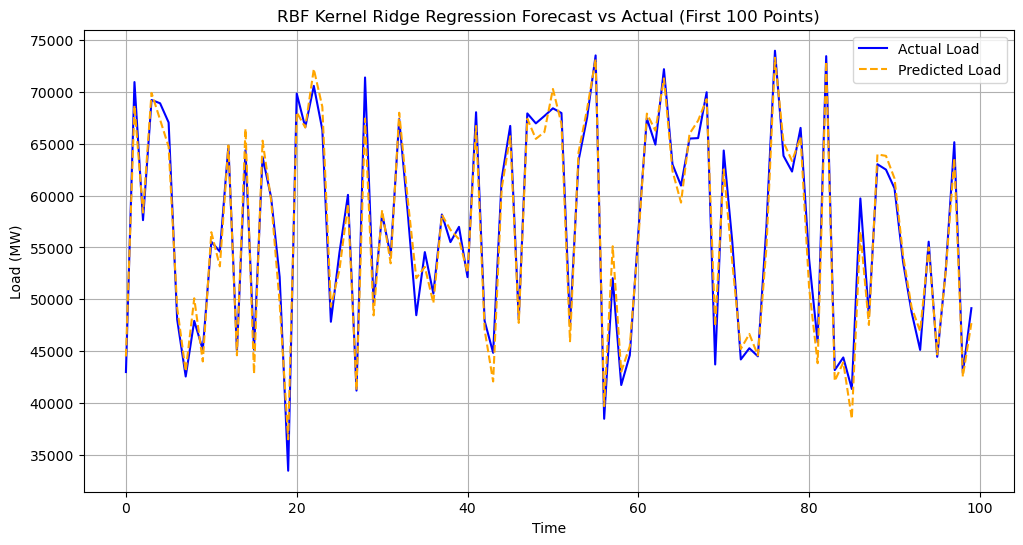

In [5]:
# Step 1: Tune Alpha & Gamma Using the Validation Set
best_alpha, best_gamma, best_mape = None, None, float("inf")

alpha_values = [0.1, 1.0, 10.0]
gamma_values = [0.01, 0.1, 1.0]

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
        krr.fit(X_train_scaled, y_train)
        val_predictions = krr.predict(X_val_scaled)
        val_mape = mape(y_val, val_predictions)

        print(f"Alpha={alpha}, Gamma={gamma} → Validation MAPE: {val_mape:.4f}")

        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model
final_krr = KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Final Model
test_predictions = final_krr.predict(X_test_scaled)

test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

# Step 4: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("RBF Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

- Electricity load is driven by many factors such as time
- The RBF kernel performs very well in capturing these dependencies 
- Results show that MAPE is at 0.022 (2.2%)

## Polynomial Kernel

The polynomial kernel captures non-linear relationships by raising input features to a power.

Alpha=0.1, Gamma=0.01, Degree=3 → Validation MAPE: 0.0265
Alpha=0.1, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=0.1, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263
Alpha=1.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0268
Alpha=1.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=1.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263
Alpha=10.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0272
Alpha=10.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=10.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263

Best Alpha: 10.0, Best Gamma: 0.1, Best Validation MAPE: 0.0263

Final Test MAPE: 0.0260
Final Test MAE: 1411.2430
Final Test RMSE: 1866.0653
Final Test R² Score: 0.9655


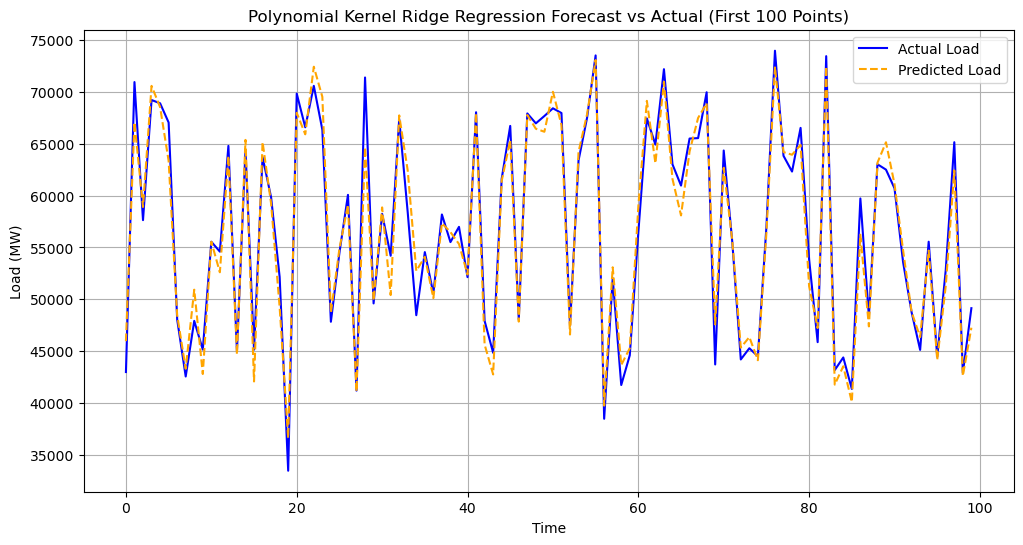

In [5]:
best_alpha, best_gamma, best_mape = None, None, float("inf")
degree = 3

alpha_values = [0.1, 1.0, 10.0]
gamma_values = [0.01, 0.1, 1.0]

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='poly', alpha=alpha, gamma=gamma, degree=degree)
        krr.fit(X_train_scaled, y_train)
        val_predictions = krr.predict(X_val_scaled)
        val_mape = mape(y_val, val_predictions)
        print(f"Alpha={alpha}, Gamma={gamma}, Degree={degree} → Validation MAPE: {val_mape:.4f}")
        
        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

final_krr_poly = KernelRidge(kernel='poly', alpha=best_alpha, gamma=best_gamma, degree=degree)
final_krr_poly.fit(X_train_scaled, y_train)

test_predictions_poly = final_krr_poly.predict(X_test_scaled)

test_mape_poly = mape(y_test, test_predictions_poly)
test_mae_poly = mean_absolute_error(y_test, test_predictions_poly)
test_rmse_poly = np.sqrt(mean_squared_error(y_test, test_predictions_poly))
test_r2_poly = r2_score(y_test, test_predictions_poly)

print(f"\nFinal Test MAPE: {test_mape_poly:.4f}")
print(f"Final Test MAE: {test_mae_poly:.4f}")
print(f"Final Test RMSE: {test_rmse_poly:.4f}")
print(f"Final Test R² Score: {test_r2_poly:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions_poly[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Polynomial Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


- If the relationship between time features and electricity load follow a structured pattern it will be useful
- The Polynomial Kernal found a strong correlation btween time and electricity load
- Results show Mape is 0.026 (2.6%)

## Analysis

- Linear KRR failed due to its inability to capture complex demand variations. It also had the highest MAPE value over 1
- RBF KRR performed the best, indicating electricity load follows highly non-linear trends with the lowest MAPE of 0.022
-  Polynomial KRR performed decently, but not as well as RBF due to its rigid structure. Has the second lowest MAPE of 0.026

## Reducing size


In [6]:
# Reduce dataset by taking a random subset
subset_fraction = 0.5
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=subset_fraction, random_state=42)

# Split the reduced dataset into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Reduced Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Reduced Training size: 15338, Validation size: 3287, Test size: 3287


## Manual Implementation


Final Test MAPE: 0.0230
Final Test MAE: 1248.3205
Final Test RMSE: 1636.3318
Final Test R² Score: 0.9733


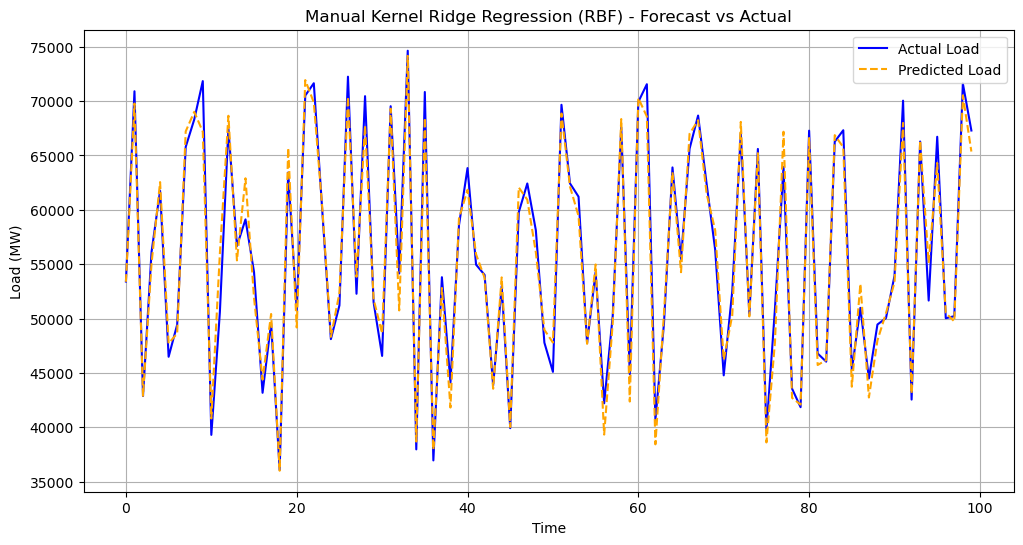

In [7]:
def rbf_kernel(X1, X2, gamma):
    sq_dists = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

best_alpha = 0.1
best_gamma = 1.0

K_train_final = rbf_kernel(X_train_scaled, X_train_scaled, best_gamma)
n_samples = K_train_final.shape[0]
I = np.eye(n_samples)

alpha_vec_final = np.linalg.pinv(K_train_final + best_alpha * I) @ y_train

K_test = rbf_kernel(X_test_scaled, X_train_scaled, best_gamma)
test_predictions = K_test @ alpha_vec_final

test_mape = mape(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Manual Kernel Ridge Regression (RBF) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()
